## ICU Length of stay using LightGBM Model & Tranformer  Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv
#/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv

In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Respiratory_rate,patient's_observation_of_Heart_rate,patient's_observation_of_Body_Weight,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_MCHC_Massvolume_by_Automated_count,patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma,...,patient's_observation_of_Sodium_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Monocytes100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Lymphocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Glucose_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Basophils100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,patient's most seen observation,patient_obs_count,patient_obs_count_unique
126225,1cde8221-e560-455d-a5f6-3987c7bd296f,0,0,0,0,0,75.5,0,0,0,...,0,0,0,0,0,0,0,Oxygen_saturation_in_Arterial_blood,1,1
8870634,ba5bdaf0-ecdf-442b-b89f-ba136848bf92,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Neutrophils100_leukocytes_in_Blood_by_Automate...,3,3
10854037,3ee42e2c-e2fb-419c-93d6-0bd3d0e6f18e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Albumin_Massvolume_in_Serum_or_Plasma,1,1
4593509,66e8525f-4f1d-4940-99b4-654648bf1b5c,0,0,0,0,0,0,0,0,0,...,0,12.1,0,0,0,0,0,Monocytes100_leukocytes_in_Blood_by_Automated_...,2,2
11714425,357a37ea-b038-4438-aef4-60e3a946a2ba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,73.9,0,0,Glucose_Massvolume_in_Serum_or_Plasma,2,2


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 751 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_MCHC_Massvolume_by_Automated_count",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Erythrocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Bil

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

## LightGBM

##### Let's start with initial LightGBM model. After seeing the feature importance plot, we will reduce features to top 40. Then we will see if it performs better with top40 features

In [55]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [56]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.506136342235291

In [57]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.7200525117298076

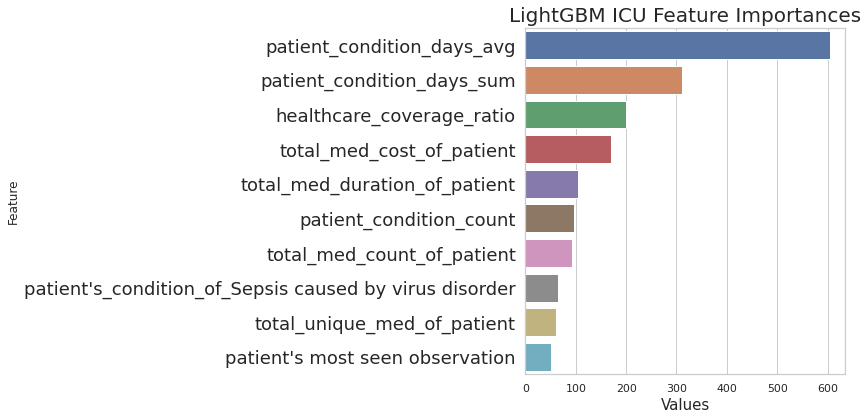

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [59]:
top30_features = feature_imp.sort_values("Value", ascending = False)[:30].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top30_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [60]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [61]:
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.4920408878898692

In [62]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.7255648692988546

#### It's indeed performing a bit better than initial model, by looking at both validation and test result we can say that

#### Let's tune some hyperparameters!

In [63]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = KFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 1.5, 'num_leaves': 4, 'num_iterations': 100, 'min_child_weight': 1, 'max_depth': 10, 'colsample_bytree': 0.7}


{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}

In [64]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Validation Result {}".format(val_result2))
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)
print("Test Result {}".format(lgb_tuned_rmse))

Validation Result 1.496936546681486
Test Result 1.7287630354324381


In [65]:
results = pd.DataFrame(test.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.head()

,index,real,preds
0,0,17.0,17.291419
1,1,14.0,13.919950
2,2,18.0,17.316391
3,3,19.0,18.901641
4,4,19.0,20.014997


In [66]:
results = pd.DataFrame(test.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.min()

index     0.000000
real     11.000000
preds    11.740367
dtype: float64

In [67]:
results = pd.DataFrame(test.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.max()

index    83.000000
real     28.000000
preds    21.620242
dtype: float64

In [68]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

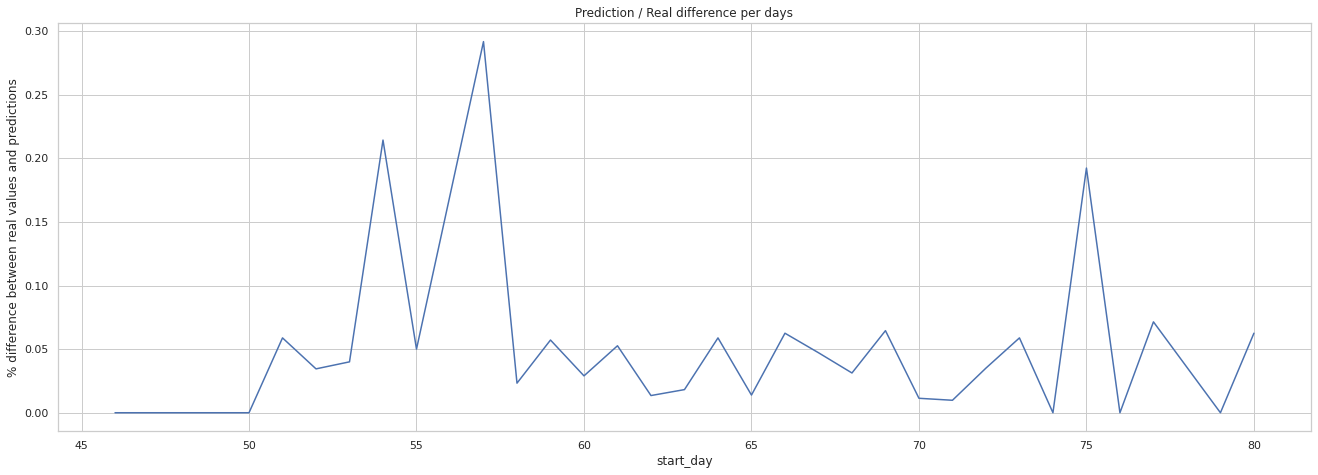

In [69]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

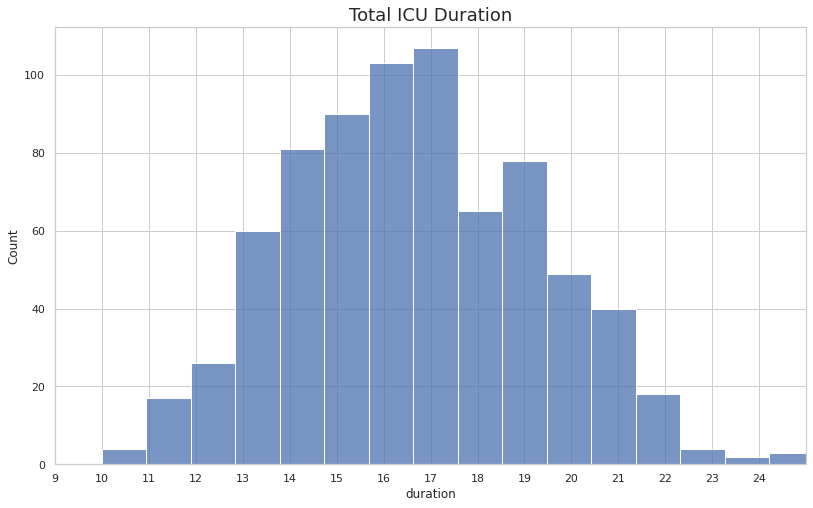

In [125]:
plt.figure(figsize = (12,8))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,25,1))
plt.xlim(9,25)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

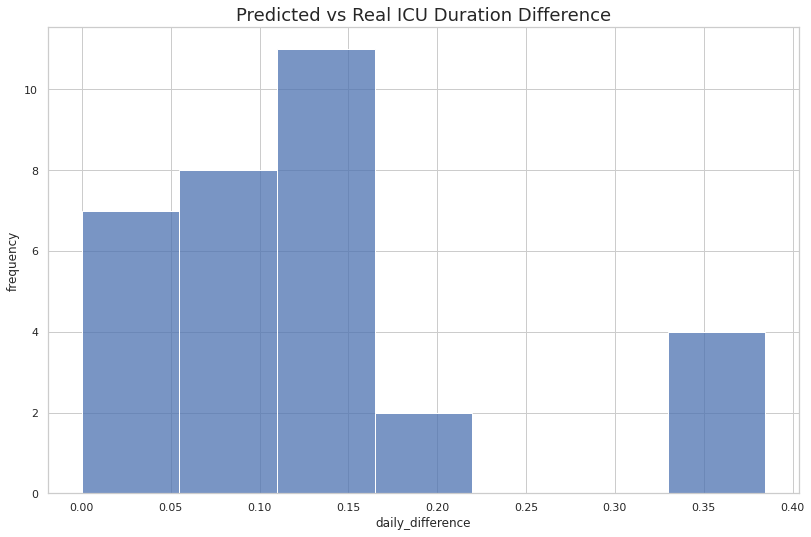

In [126]:
plt.figure(figsize = (12,8))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

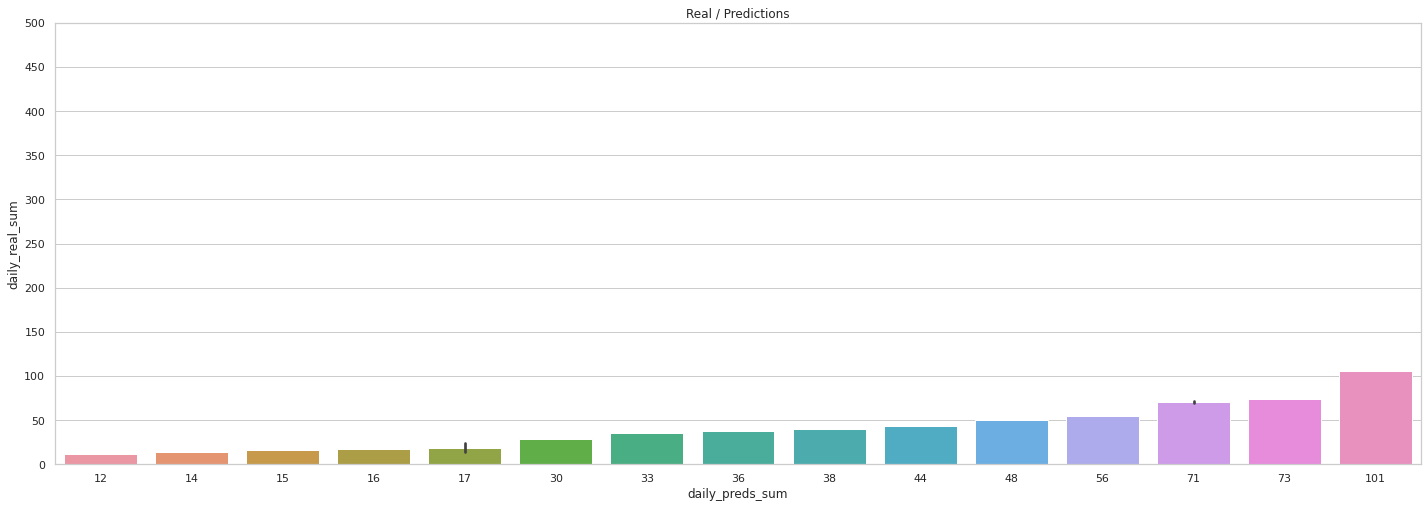

In [72]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

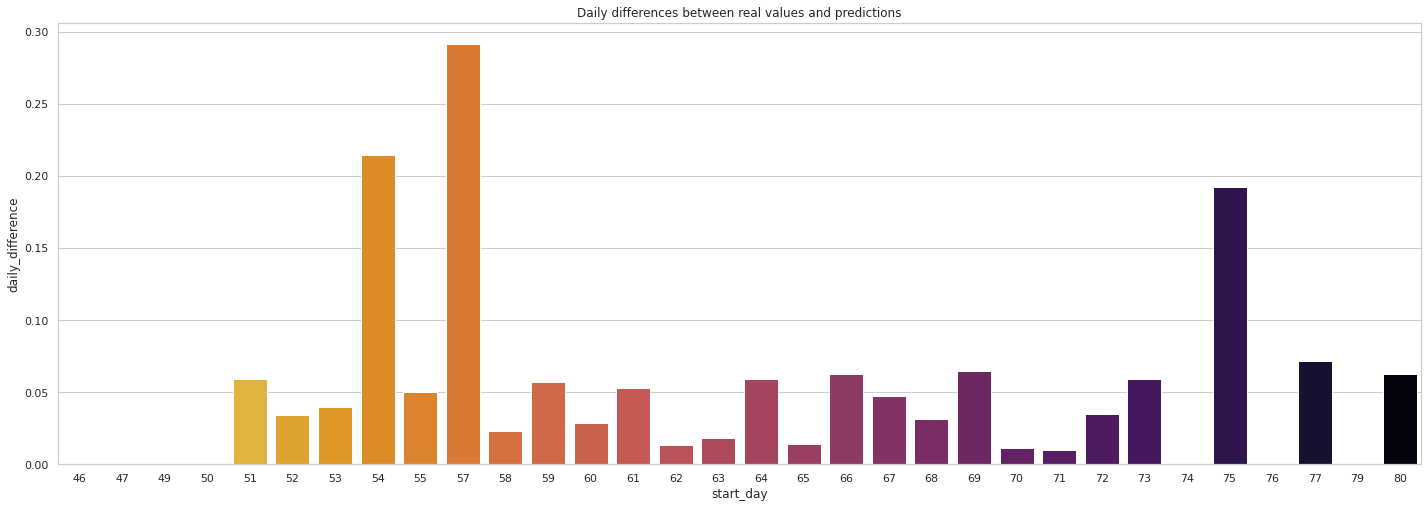

In [73]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [74]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [75]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [78]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [79]:
y = data['duration']
LABEL = "duration"

In [80]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [81]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [82]:
CATEGORICAL_FEATURES

["patient's most seen observation",
 'COUNTY',
 'MARITAL',
 'GENDER',
 "patient's most seen condition"]

In [83]:
NUMERIC_FEATURES

['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'total_med_cost_of_patient',
 'total_med_duration_of_patient',
 'patient_condition_count',
 'total_med_count_of_patient',
 "patient's_condition_of_Sepsis caused by virus disorder",
 'total_unique_med_of_patient',
 "patient's_condition_of_Dyspnea finding",
 "patient's_medication_of_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_medication_of_NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Fatigue finding",
 'patient_obs_count',
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Sore throat symptom finding",
 'unique_immunizations',
 "patient's_medicatio

In [84]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [85]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

Text(0.5, 1.0, 'Distributions of duration in each dataset')

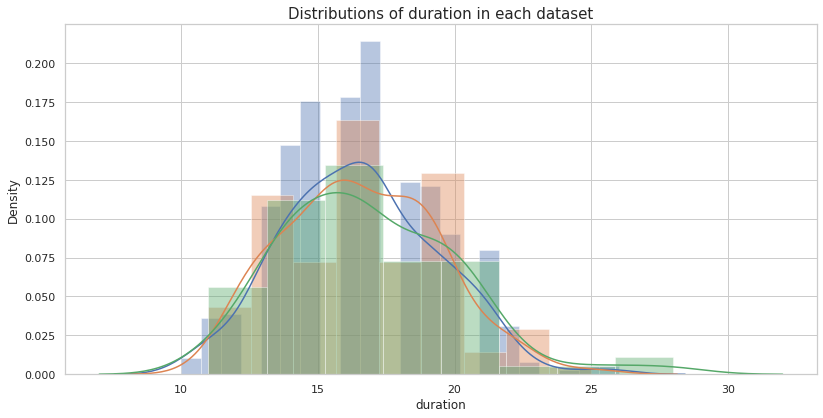

In [86]:
plt.figure(figsize = (12,6))
sns.distplot(X_train[LABEL])
sns.distplot(X_val[LABEL])
sns.distplot(test_data[LABEL])
plt.title("Distributions of duration in each dataset", fontsize = 15)

In [87]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [88]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [89]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 14s 806ms/step - loss: 275.9157 - output_loss: 275.9157 - output_rmse: 16.6107 - val_loss: 211.0775 - val_output_loss: 211.0775 - val_output_rmse: 14.5285
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 226.3090 - output_loss: 226.3090 - output_rmse: 15.0436 - val_loss: 189.6762 - val_output_loss: 189.6762 - val_output_rmse: 13.7723
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 199.8483 - output_loss: 199.8483 - output_rmse: 14.1368 - val_loss: 178.6510 - val_output_loss: 178.6510 - val_output_rmse: 13.3660
Epoch 4/150
2/2 [==============================] - 0s 59ms/step - loss: 185.2570 - output_loss: 185.2570 - output_rmse: 13.6109 - val_loss: 169.7241 - val_output_loss: 169.7241 - val_output_rmse: 13.0278
Epoch 5/150
2/2 [==============================] - 0s 56ms/step - loss: 175.4888 - output_loss: 175.4888 - output_rmse: 13.2472 - val_loss: 165.0762 - val_output_loss: 165.0762 - val

In [90]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 5s 678ms/step - loss: 280.6808 - output_loss: 280.6808 - output_rmse: 16.7535 - val_loss: 276.7415 - val_output_loss: 276.7415 - val_output_rmse: 16.6355
Epoch 2/150
2/2 [==============================] - 0s 49ms/step - loss: 277.3196 - output_loss: 277.3196 - output_rmse: 16.6529 - val_loss: 269.8326 - val_output_loss: 269.8326 - val_output_rmse: 16.4266
Epoch 3/150
2/2 [==============================] - 0s 50ms/step - loss: 275.3270 - output_loss: 275.3270 - output_rmse: 16.5930 - val_loss: 263.5366 - val_output_loss: 263.5366 - val_output_rmse: 16.2338
Epoch 4/150
2/2 [==============================] - 0s 48ms/step - loss: 271.0976 - output_loss: 271.0976 - output_rmse: 16.4650 - val_loss: 256.6643 - val_output_loss: 256.6643 - val_output_rmse: 16.0207
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 264.9074 - output_loss: 264.9074 - output_rmse: 16.2760 - val_loss: 251.2628 - val_output_loss: 251.2628 - val_

In [91]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 571ms/step


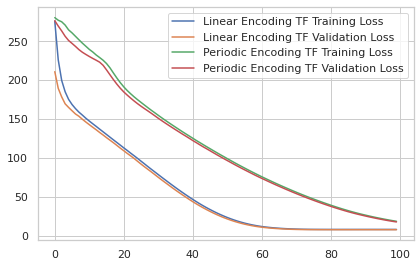

In [92]:
plt.plot(ft_linear_history.history['loss'][:100], label='Linear Encoding TF Training Loss')
plt.plot(ft_linear_history.history['val_loss'][:100], label='Linear Encoding TF Validation Loss')
plt.plot(ft_periodic_history.history['loss'][:100], label='Periodic Encoding TF Training Loss')
plt.plot(ft_periodic_history.history['val_loss'][:100], label='Periodic Encoding TF Validation Loss')
plt.legend()

#fig, ax = plt.subplots(nrows=1, ncols=2)
#ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
#ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
#ax[0].legend()
#ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
#ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
#ax[1].legend()

plt.show()

In [93]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.0 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [94]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-31 08:39:50,658] A new study created in memory with name: no-name-bdd12cef-0cae-451d-adc6-1b41a495a9d6


Epoch 1/150
2/2 [==============================] - 5s 756ms/step - loss: 272.2182 - output_loss: 272.2182 - output_rmse: 16.4990 - val_loss: 135.6783 - val_output_loss: 135.6783 - val_output_rmse: 11.6481
Epoch 2/150
2/2 [==============================] - 0s 56ms/step - loss: 145.1507 - output_loss: 145.1507 - output_rmse: 12.0479 - val_loss: 84.1704 - val_output_loss: 84.1704 - val_output_rmse: 9.1744
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 95.7830 - output_loss: 95.7830 - output_rmse: 9.7869 - val_loss: 60.8183 - val_output_loss: 60.8183 - val_output_rmse: 7.7986
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 69.0921 - output_loss: 69.0921 - output_rmse: 8.3122 - val_loss: 39.0415 - val_output_loss: 39.0415 - val_output_rmse: 6.2483
Epoch 5/150
2/2 [==============================] - 0s 60ms/step - loss: 45.6260 - output_loss: 45.6260 - output_rmse: 6.7547 - val_loss: 22.7298 - val_output_loss: 22.7298 - val_output_rmse: 4.7676


[I 2023-01-31 08:40:09,288] Trial 0 finished with value: 1.9501008376706588 and parameters: {'numerical_bins': 43, 'embedding_dim': 86, 'depth': 2, 'heads': 4, 'attn_dropout': 0.39300576909927526, 'ff_dropout': 0.13023925964257438}. Best is trial 0 with value: 1.9501008376706588.


Epoch 1/150
2/2 [==============================] - 4s 561ms/step - loss: 242.1649 - output_loss: 242.1649 - output_rmse: 15.5616 - val_loss: 91.4027 - val_output_loss: 91.4027 - val_output_rmse: 9.5605
Epoch 2/150
2/2 [==============================] - 0s 51ms/step - loss: 92.5578 - output_loss: 92.5578 - output_rmse: 9.6207 - val_loss: 50.8840 - val_output_loss: 50.8840 - val_output_rmse: 7.1333
Epoch 3/150
2/2 [==============================] - 0s 50ms/step - loss: 51.9378 - output_loss: 51.9378 - output_rmse: 7.2068 - val_loss: 29.6841 - val_output_loss: 29.6841 - val_output_rmse: 5.4483
Epoch 4/150
2/2 [==============================] - 0s 46ms/step - loss: 30.8005 - output_loss: 30.8005 - output_rmse: 5.5498 - val_loss: 18.2538 - val_output_loss: 18.2538 - val_output_rmse: 4.2724
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 19.1170 - output_loss: 19.1170 - output_rmse: 4.3723 - val_loss: 11.7651 - val_output_loss: 11.7651 - val_output_rmse: 3.4300
Epoch 

[I 2023-01-31 08:40:29,825] Trial 1 finished with value: 1.8468932577483657 and parameters: {'numerical_bins': 101, 'embedding_dim': 69, 'depth': 2, 'heads': 7, 'attn_dropout': 0.1528201518895153, 'ff_dropout': 0.012775752172416999}. Best is trial 1 with value: 1.8468932577483657.


Epoch 1/150
2/2 [==============================] - 6s 820ms/step - loss: 260.0561 - output_loss: 260.0561 - output_rmse: 16.1263 - val_loss: 68.4138 - val_output_loss: 68.4138 - val_output_rmse: 8.2713
Epoch 2/150
2/2 [==============================] - 0s 69ms/step - loss: 71.0142 - output_loss: 71.0142 - output_rmse: 8.4270 - val_loss: 27.1819 - val_output_loss: 27.1819 - val_output_rmse: 5.2136
Epoch 3/150
2/2 [==============================] - 0s 67ms/step - loss: 28.4927 - output_loss: 28.4927 - output_rmse: 5.3379 - val_loss: 14.4883 - val_output_loss: 14.4883 - val_output_rmse: 3.8063
Epoch 4/150
2/2 [==============================] - 0s 66ms/step - loss: 15.2127 - output_loss: 15.2127 - output_rmse: 3.9003 - val_loss: 9.6740 - val_output_loss: 9.6740 - val_output_rmse: 3.1103
Epoch 5/150
2/2 [==============================] - 0s 69ms/step - loss: 10.1327 - output_loss: 10.1327 - output_rmse: 3.1832 - val_loss: 8.0155 - val_output_loss: 8.0155 - val_output_rmse: 2.8312
Epoch 6/15

1/1 [==============================] - 1s 702ms/step


[I 2023-01-31 08:41:04,369] Trial 2 finished with value: 1.9300823121076651 and parameters: {'numerical_bins': 175, 'embedding_dim': 81, 'depth': 4, 'heads': 6, 'attn_dropout': 0.4724404149171178, 'ff_dropout': 0.018393881939064827}. Best is trial 1 with value: 1.8468932577483657.


Epoch 1/150
2/2 [==============================] - 4s 566ms/step - loss: 272.4330 - output_loss: 272.4330 - output_rmse: 16.5055 - val_loss: 197.3556 - val_output_loss: 197.3556 - val_output_rmse: 14.0483
Epoch 2/150
2/2 [==============================] - 0s 45ms/step - loss: 209.6542 - output_loss: 209.6542 - output_rmse: 14.4794 - val_loss: 140.2462 - val_output_loss: 140.2462 - val_output_rmse: 11.8426
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 162.1866 - output_loss: 162.1866 - output_rmse: 12.7353 - val_loss: 106.5160 - val_output_loss: 106.5160 - val_output_rmse: 10.3207
Epoch 4/150
2/2 [==============================] - 0s 45ms/step - loss: 132.3421 - output_loss: 132.3421 - output_rmse: 11.5040 - val_loss: 83.4874 - val_output_loss: 83.4874 - val_output_rmse: 9.1371
Epoch 5/150
2/2 [==============================] - 0s 46ms/step - loss: 107.6829 - output_loss: 107.6829 - output_rmse: 10.3770 - val_loss: 67.2677 - val_output_loss: 67.2677 - val_outpu

1/1 [==============================] - 0s 462ms/step


[I 2023-01-31 08:41:23,102] Trial 3 finished with value: 1.915504982198053 and parameters: {'numerical_bins': 101, 'embedding_dim': 55, 'depth': 2, 'heads': 4, 'attn_dropout': 0.49693374164720217, 'ff_dropout': 0.285253756899473}. Best is trial 1 with value: 1.8468932577483657.


Epoch 1/150
2/2 [==============================] - 7s 824ms/step - loss: 257.7211 - output_loss: 257.7211 - output_rmse: 16.0537 - val_loss: 152.4014 - val_output_loss: 152.4014 - val_output_rmse: 12.3451
Epoch 2/150
2/2 [==============================] - 0s 66ms/step - loss: 153.4475 - output_loss: 153.4475 - output_rmse: 12.3874 - val_loss: 108.2276 - val_output_loss: 108.2276 - val_output_rmse: 10.4032
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 109.0979 - output_loss: 109.0979 - output_rmse: 10.4450 - val_loss: 86.2144 - val_output_loss: 86.2144 - val_output_rmse: 9.2852
Epoch 4/150
2/2 [==============================] - 0s 83ms/step - loss: 86.7679 - output_loss: 86.7679 - output_rmse: 9.3149 - val_loss: 75.4587 - val_output_loss: 75.4587 - val_output_rmse: 8.6867
Epoch 5/150
2/2 [==============================] - 0s 65ms/step - loss: 75.7009 - output_loss: 75.7009 - output_rmse: 8.7006 - val_loss: 66.1794 - val_output_loss: 66.1794 - val_output_rmse: 8

[I 2023-01-31 08:41:49,496] Trial 4 finished with value: 1.990400799371736 and parameters: {'numerical_bins': 191, 'embedding_dim': 64, 'depth': 4, 'heads': 5, 'attn_dropout': 0.2697342247017792, 'ff_dropout': 0.006942324327028737}. Best is trial 1 with value: 1.8468932577483657.


Epoch 1/150
2/2 [==============================] - 3s 420ms/step - loss: 272.9781 - output_loss: 272.9781 - output_rmse: 16.5220 - val_loss: 219.4396 - val_output_loss: 219.4396 - val_output_rmse: 14.8135
Epoch 2/150
2/2 [==============================] - 0s 39ms/step - loss: 222.7674 - output_loss: 222.7674 - output_rmse: 14.9254 - val_loss: 190.8716 - val_output_loss: 190.8716 - val_output_rmse: 13.8156
Epoch 3/150
2/2 [==============================] - 0s 34ms/step - loss: 196.4292 - output_loss: 196.4292 - output_rmse: 14.0153 - val_loss: 178.3176 - val_output_loss: 178.3176 - val_output_rmse: 13.3536
Epoch 4/150
2/2 [==============================] - 0s 36ms/step - loss: 183.4993 - output_loss: 183.4993 - output_rmse: 13.5462 - val_loss: 166.0452 - val_output_loss: 166.0452 - val_output_rmse: 12.8859
Epoch 5/150
2/2 [==============================] - 0s 37ms/step - loss: 170.7873 - output_loss: 170.7873 - output_rmse: 13.0686 - val_loss: 155.3595 - val_output_loss: 155.3595 - val_

[I 2023-01-31 08:42:05,447] Trial 5 finished with value: 1.8067007940611033 and parameters: {'numerical_bins': 83, 'embedding_dim': 63, 'depth': 1, 'heads': 4, 'attn_dropout': 0.2462749135456439, 'ff_dropout': 0.07249040070906249}. Best is trial 5 with value: 1.8067007940611033.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 272.7292 - output_loss: 272.7292 - output_rmse: 16.5145 - val_loss: 160.0609 - val_output_loss: 160.0609 - val_output_rmse: 12.6515
Epoch 2/150
2/2 [==============================] - 0s 75ms/step - loss: 178.3543 - output_loss: 178.3543 - output_rmse: 13.3549 - val_loss: 102.1207 - val_output_loss: 102.1207 - val_output_rmse: 10.1055
Epoch 3/150
2/2 [==============================] - 0s 75ms/step - loss: 119.8820 - output_loss: 119.8820 - output_rmse: 10.9491 - val_loss: 76.6761 - val_output_loss: 76.6761 - val_output_rmse: 8.7565
Epoch 4/150
2/2 [==============================] - 0s 76ms/step - loss: 88.9723 - output_loss: 88.9723 - output_rmse: 9.4325 - val_loss: 61.2944 - val_output_loss: 61.2944 - val_output_rmse: 7.8291
Epoch 5/150
2/2 [==============================] - 0s 76ms/step - loss: 69.9367 - output_loss: 69.9367 - output_rmse: 8.3628 - val_loss: 52.4153 - val_output_loss: 52.4153 - val_output_rmse: 7.23

[I 2023-01-31 08:42:23,860] Trial 6 finished with value: 3.21732311571836 and parameters: {'numerical_bins': 61, 'embedding_dim': 45, 'depth': 6, 'heads': 7, 'attn_dropout': 0.36946585890773626, 'ff_dropout': 0.2588604691962273}. Best is trial 5 with value: 1.8067007940611033.


Epoch 1/150
2/2 [==============================] - 3s 451ms/step - loss: 280.5709 - output_loss: 280.5709 - output_rmse: 16.7502 - val_loss: 216.9323 - val_output_loss: 216.9323 - val_output_rmse: 14.7286
Epoch 2/150
2/2 [==============================] - 0s 36ms/step - loss: 223.9239 - output_loss: 223.9239 - output_rmse: 14.9641 - val_loss: 165.9627 - val_output_loss: 165.9627 - val_output_rmse: 12.8827
Epoch 3/150
2/2 [==============================] - 0s 43ms/step - loss: 172.5072 - output_loss: 172.5072 - output_rmse: 13.1342 - val_loss: 139.3674 - val_output_loss: 139.3674 - val_output_rmse: 11.8054
Epoch 4/150
2/2 [==============================] - 0s 39ms/step - loss: 144.0749 - output_loss: 144.0749 - output_rmse: 12.0031 - val_loss: 119.7180 - val_output_loss: 119.7180 - val_output_rmse: 10.9416
Epoch 5/150
2/2 [==============================] - 0s 36ms/step - loss: 125.3183 - output_loss: 125.3183 - output_rmse: 11.1946 - val_loss: 107.2080 - val_output_loss: 107.2080 - val_

[I 2023-01-31 08:42:33,079] Trial 7 finished with value: 3.2213163956968036 and parameters: {'numerical_bins': 168, 'embedding_dim': 60, 'depth': 1, 'heads': 4, 'attn_dropout': 0.23975873625900518, 'ff_dropout': 0.08501997146453494}. Best is trial 5 with value: 1.8067007940611033.


Epoch 1/150
2/2 [==============================] - 3s 426ms/step - loss: 278.5710 - output_loss: 278.5710 - output_rmse: 16.6904 - val_loss: 217.2033 - val_output_loss: 217.2033 - val_output_rmse: 14.7378
Epoch 2/150
2/2 [==============================] - 0s 36ms/step - loss: 227.8341 - output_loss: 227.8341 - output_rmse: 15.0942 - val_loss: 191.4777 - val_output_loss: 191.4777 - val_output_rmse: 13.8375
Epoch 3/150
2/2 [==============================] - 0s 38ms/step - loss: 201.0894 - output_loss: 201.0894 - output_rmse: 14.1806 - val_loss: 179.8370 - val_output_loss: 179.8370 - val_output_rmse: 13.4103
Epoch 4/150
2/2 [==============================] - 0s 39ms/step - loss: 188.0086 - output_loss: 188.0086 - output_rmse: 13.7116 - val_loss: 169.7899 - val_output_loss: 169.7899 - val_output_rmse: 13.0303
Epoch 5/150
2/2 [==============================] - 0s 37ms/step - loss: 179.0246 - output_loss: 179.0246 - output_rmse: 13.3800 - val_loss: 163.0924 - val_output_loss: 163.0924 - val_

[I 2023-01-31 08:42:49,608] Trial 8 finished with value: 2.309259864578029 and parameters: {'numerical_bins': 183, 'embedding_dim': 36, 'depth': 1, 'heads': 8, 'attn_dropout': 0.24062152617053373, 'ff_dropout': 0.21995047286253483}. Best is trial 5 with value: 1.8067007940611033.


Epoch 1/150
2/2 [==============================] - 6s 809ms/step - loss: 270.9873 - output_loss: 270.9873 - output_rmse: 16.4617 - val_loss: 194.0543 - val_output_loss: 194.0543 - val_output_rmse: 13.9303
Epoch 2/150
2/2 [==============================] - 0s 61ms/step - loss: 207.5695 - output_loss: 207.5695 - output_rmse: 14.4073 - val_loss: 158.4539 - val_output_loss: 158.4539 - val_output_rmse: 12.5878
Epoch 3/150
2/2 [==============================] - 0s 65ms/step - loss: 174.2061 - output_loss: 174.2061 - output_rmse: 13.1987 - val_loss: 145.1877 - val_output_loss: 145.1877 - val_output_rmse: 12.0494
Epoch 4/150
2/2 [==============================] - 0s 64ms/step - loss: 153.3098 - output_loss: 153.3098 - output_rmse: 12.3818 - val_loss: 129.5959 - val_output_loss: 129.5959 - val_output_rmse: 11.3840
Epoch 5/150
2/2 [==============================] - 0s 61ms/step - loss: 137.8290 - output_loss: 137.8290 - output_rmse: 11.7401 - val_loss: 115.4327 - val_output_loss: 115.4327 - val_

[I 2023-01-31 08:43:06,359] Trial 9 finished with value: 3.2210378836818734 and parameters: {'numerical_bins': 177, 'embedding_dim': 44, 'depth': 4, 'heads': 5, 'attn_dropout': 0.08369520794701646, 'ff_dropout': 0.1392335090759979}. Best is trial 5 with value: 1.8067007940611033.


Number of finished trials: 10
Best trial: {'numerical_bins': 83, 'embedding_dim': 63, 'depth': 1, 'heads': 4, 'attn_dropout': 0.2462749135456439, 'ff_dropout': 0.07249040070906249}


In [95]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=83,
    embedding_dim=63,
    depth=1,
    heads=4,
    attn_dropout= 0.2462,
    ff_dropout= 0.0724,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 4s 591ms/step - loss: 276.3141 - output_loss: 276.3141 - output_rmse: 16.6227 - val_loss: 193.3415 - val_output_loss: 193.3415 - val_output_rmse: 13.9047
Epoch 2/250
2/2 [==============================] - 0s 47ms/step - loss: 196.8835 - output_loss: 196.8835 - output_rmse: 14.0315 - val_loss: 155.6221 - val_output_loss: 155.6221 - val_output_rmse: 12.4749
Epoch 3/250
2/2 [==============================] - 0s 49ms/step - loss: 158.6044 - output_loss: 158.6044 - output_rmse: 12.5938 - val_loss: 118.5311 - val_output_loss: 118.5311 - val_output_rmse: 10.8872
Epoch 4/250
2/2 [==============================] - 0s 65ms/step - loss: 124.1751 - output_loss: 124.1751 - output_rmse: 11.1434 - val_loss: 93.5683 - val_output_loss: 93.5683 - val_output_rmse: 9.6731
Epoch 5/250
2/2 [==============================] - 0s 54ms/step - loss: 101.3392 - output_loss: 101.3392 - output_rmse: 10.0667 - val_loss: 81.3315 - val_output_loss: 81.3315 - val_outpu

In [96]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 342ms/step


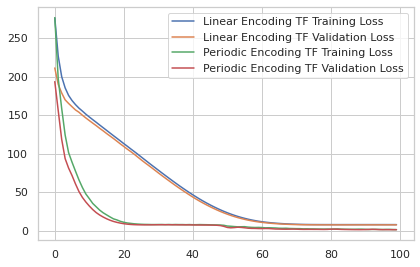

In [97]:
plt.plot(ft_linear_history.history['loss'][:100], label='Linear Encoding TF Training Loss')
plt.plot(ft_linear_history.history['val_loss'][:100], label='Linear Encoding TF Validation Loss')
plt.plot(ft_periodic_history.history['loss'][:100], label='Periodic Encoding TF Training Loss')
plt.plot(ft_periodic_history.history['val_loss'][:100], label='Periodic Encoding TF Validation Loss')
plt.legend()

#fig, ax = plt.subplots(nrows=1, ncols=2)
#ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
#ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
#ax[0].legend()
#ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
#ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
#ax[1].legend()

plt.show()

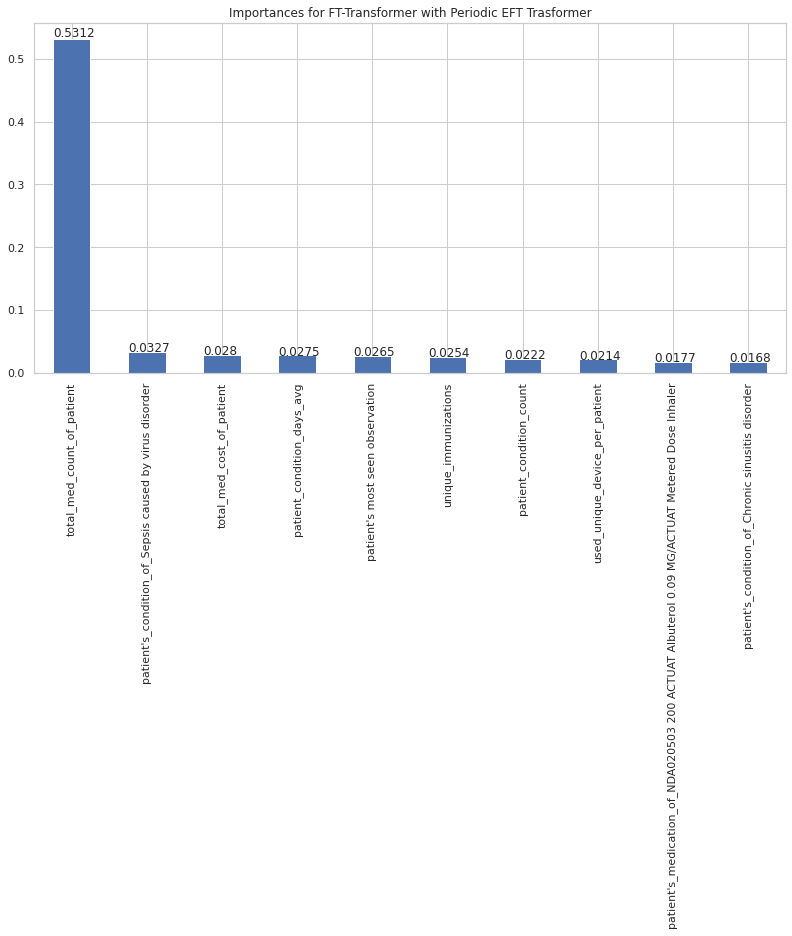

In [98]:
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)[:10]
    
    plt.figure(figsize=(12,6))
    ax = imps_sorted.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()
    
    return imps_sorted

# Model output
periodic_importances = periodic_tuned_test_preds['importances']

# Exclude attention from CLS token to CLS token
periodic_importances_df = pd.DataFrame(periodic_importances[:, :-1], columns = FEATURES)

# Plot and store
periodic_total_importances = get_model_importances(
    periodic_importances_df, title="Importances for FT-Transformer with Periodic EFT Trasformer"
)

### Periodic Encoding FT Transformer Model Graphs

In [99]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

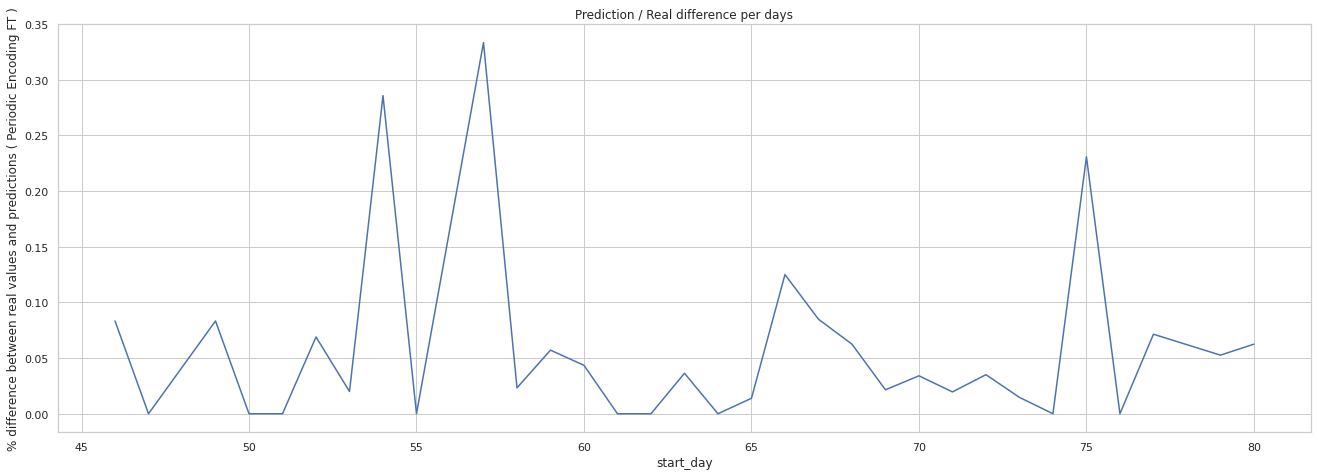

In [100]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

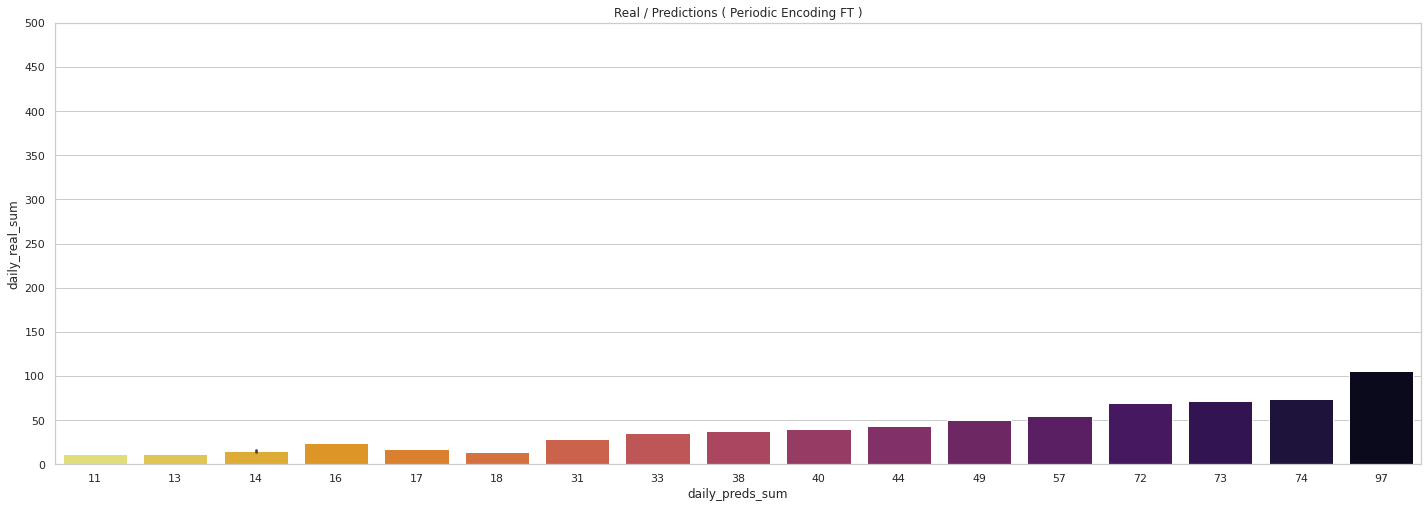

In [101]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

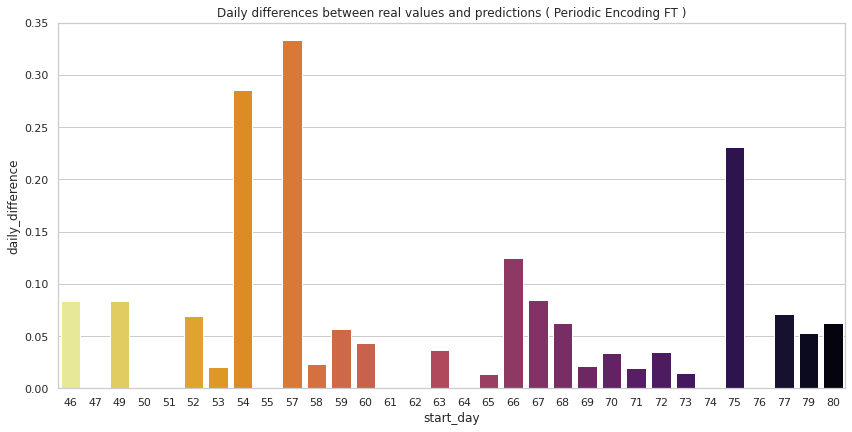

In [102]:
plt.figure(figsize = (12,6))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [103]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-31 08:46:31,524] A new study created in memory with name: no-name-7807638f-821d-44a2-9e3d-ca764dac53a6


Epoch 1/150
2/2 [==============================] - 3s 422ms/step - loss: 269.4647 - output_loss: 269.4647 - output_rmse: 16.4154 - val_loss: 196.9857 - val_output_loss: 196.9857 - val_output_rmse: 14.0352
Epoch 2/150
2/2 [==============================] - 0s 34ms/step - loss: 216.0009 - output_loss: 216.0009 - output_rmse: 14.6970 - val_loss: 165.1498 - val_output_loss: 165.1498 - val_output_rmse: 12.8511
Epoch 3/150
2/2 [==============================] - 0s 40ms/step - loss: 190.0077 - output_loss: 190.0077 - output_rmse: 13.7843 - val_loss: 144.6814 - val_output_loss: 144.6814 - val_output_rmse: 12.0284
Epoch 4/150
2/2 [==============================] - 0s 33ms/step - loss: 167.4154 - output_loss: 167.4154 - output_rmse: 12.9389 - val_loss: 128.0394 - val_output_loss: 128.0394 - val_output_rmse: 11.3154
Epoch 5/150
2/2 [==============================] - 0s 38ms/step - loss: 150.4478 - output_loss: 150.4478 - output_rmse: 12.2657 - val_loss: 114.4853 - val_output_loss: 114.4853 - val_

[I 2023-01-31 08:46:39,442] Trial 0 finished with value: 3.2079920023810655 and parameters: {'numerical_bins': 184, 'embedding_dim': 36, 'depth': 1, 'heads': 6, 'attn_dropout': 0.012223704293928161, 'ff_dropout': 0.3660968743222394}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 230.3312 - output_loss: 230.3312 - output_rmse: 15.1767 - val_loss: 75.6113 - val_output_loss: 75.6113 - val_output_rmse: 8.6955
Epoch 2/150
2/2 [==============================] - 0s 81ms/step - loss: 87.0962 - output_loss: 87.0962 - output_rmse: 9.3325 - val_loss: 47.3927 - val_output_loss: 47.3927 - val_output_rmse: 6.8842
Epoch 3/150
2/2 [==============================] - 0s 76ms/step - loss: 54.4852 - output_loss: 54.4852 - output_rmse: 7.3814 - val_loss: 34.7071 - val_output_loss: 34.7071 - val_output_rmse: 5.8913
Epoch 4/150
2/2 [==============================] - 0s 80ms/step - loss: 39.6268 - output_loss: 39.6268 - output_rmse: 6.2950 - val_loss: 29.0022 - val_output_loss: 29.0022 - val_output_rmse: 5.3854
Epoch 5/150
2/2 [==============================] - 0s 80ms/step - loss: 32.2595 - output_loss: 32.2595 - output_rmse: 5.6797 - val_loss: 25.2639 - val_output_loss: 25.2639 - val_output_rmse: 5.0263
Epoch 6/1

[I 2023-01-31 08:46:55,952] Trial 1 finished with value: 3.221370578504799 and parameters: {'numerical_bins': 147, 'embedding_dim': 49, 'depth': 6, 'heads': 5, 'attn_dropout': 0.3317997599027651, 'ff_dropout': 0.1916478366524364}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 279.3182 - output_loss: 279.3182 - output_rmse: 16.7128 - val_loss: 278.4328 - val_output_loss: 278.4328 - val_output_rmse: 16.6863
Epoch 2/150
2/2 [==============================] - 0s 69ms/step - loss: 275.9937 - output_loss: 275.9937 - output_rmse: 16.6131 - val_loss: 267.7882 - val_output_loss: 267.7882 - val_output_rmse: 16.3642
Epoch 3/150
2/2 [==============================] - 0s 78ms/step - loss: 272.2142 - output_loss: 272.2142 - output_rmse: 16.4989 - val_loss: 259.4899 - val_output_loss: 259.4899 - val_output_rmse: 16.1087
Epoch 4/150
2/2 [==============================] - 0s 74ms/step - loss: 266.4894 - output_loss: 266.4894 - output_rmse: 16.3245 - val_loss: 253.5243 - val_output_loss: 253.5243 - val_output_rmse: 15.9224
Epoch 5/150
2/2 [==============================] - 0s 74ms/step - loss: 259.5703 - output_loss: 259.5703 - output_rmse: 16.1112 - val_loss: 248.1727 - val_output_loss: 248.1727 - val_out

[I 2023-01-31 08:47:29,859] Trial 2 finished with value: 3.243194929776614 and parameters: {'numerical_bins': 97, 'embedding_dim': 10, 'depth': 6, 'heads': 8, 'attn_dropout': 0.44791037811511325, 'ff_dropout': 0.46653918778051895}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 4s 554ms/step - loss: 277.1216 - output_loss: 277.1216 - output_rmse: 16.6470 - val_loss: 179.4746 - val_output_loss: 179.4746 - val_output_rmse: 13.3968
Epoch 2/150
2/2 [==============================] - 0s 44ms/step - loss: 193.6933 - output_loss: 193.6933 - output_rmse: 13.9174 - val_loss: 136.3074 - val_output_loss: 136.3074 - val_output_rmse: 11.6751
Epoch 3/150
2/2 [==============================] - 0s 48ms/step - loss: 146.6077 - output_loss: 146.6077 - output_rmse: 12.1082 - val_loss: 97.7275 - val_output_loss: 97.7275 - val_output_rmse: 9.8857
Epoch 4/150
2/2 [==============================] - 0s 44ms/step - loss: 107.9524 - output_loss: 107.9524 - output_rmse: 10.3900 - val_loss: 71.8986 - val_output_loss: 71.8986 - val_output_rmse: 8.4793
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 79.9248 - output_loss: 79.9248 - output_rmse: 8.9401 - val_loss: 55.1348 - val_output_loss: 55.1348 - val_output_rmse

[I 2023-01-31 08:47:39,410] Trial 3 finished with value: 3.222364094909584 and parameters: {'numerical_bins': 161, 'embedding_dim': 74, 'depth': 2, 'heads': 2, 'attn_dropout': 0.46129512164682285, 'ff_dropout': 0.18532756907655734}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 8s 959ms/step - loss: 270.6608 - output_loss: 270.6608 - output_rmse: 16.4518 - val_loss: 120.1401 - val_output_loss: 120.1401 - val_output_rmse: 10.9608
Epoch 2/150
2/2 [==============================] - 0s 72ms/step - loss: 135.0789 - output_loss: 135.0789 - output_rmse: 11.6223 - val_loss: 58.2462 - val_output_loss: 58.2462 - val_output_rmse: 7.6319
Epoch 3/150
2/2 [==============================] - 0s 69ms/step - loss: 69.8180 - output_loss: 69.8180 - output_rmse: 8.3557 - val_loss: 35.6806 - val_output_loss: 35.6806 - val_output_rmse: 5.9733
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 42.4845 - output_loss: 42.4845 - output_rmse: 6.5180 - val_loss: 26.3895 - val_output_loss: 26.3895 - val_output_rmse: 5.1371
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 30.7220 - output_loss: 30.7220 - output_rmse: 5.5427 - val_loss: 21.7982 - val_output_loss: 21.7982 - val_output_rmse: 4.6689


[I 2023-01-31 08:47:59,362] Trial 4 finished with value: 3.219928552493346 and parameters: {'numerical_bins': 94, 'embedding_dim': 61, 'depth': 5, 'heads': 4, 'attn_dropout': 0.3556850363644983, 'ff_dropout': 0.25298114778024433}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 6s 923ms/step - loss: 276.9113 - output_loss: 276.9113 - output_rmse: 16.6407 - val_loss: 219.9956 - val_output_loss: 219.9956 - val_output_rmse: 14.8322
Epoch 2/150
2/2 [==============================] - 0s 108ms/step - loss: 251.8735 - output_loss: 251.8735 - output_rmse: 15.8705 - val_loss: 196.2709 - val_output_loss: 196.2709 - val_output_rmse: 14.0097
Epoch 3/150
2/2 [==============================] - 0s 81ms/step - loss: 220.2166 - output_loss: 220.2166 - output_rmse: 14.8397 - val_loss: 183.6990 - val_output_loss: 183.6990 - val_output_rmse: 13.5536
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 200.6635 - output_loss: 200.6635 - output_rmse: 14.1656 - val_loss: 173.4176 - val_output_loss: 173.4176 - val_output_rmse: 13.1688
Epoch 5/150
2/2 [==============================] - 0s 52ms/step - loss: 185.9339 - output_loss: 185.9339 - output_rmse: 13.6358 - val_loss: 163.3814 - val_output_loss: 163.3814 - val

[I 2023-01-31 08:48:18,988] Trial 5 finished with value: 3.21740374354726 and parameters: {'numerical_bins': 51, 'embedding_dim': 28, 'depth': 3, 'heads': 4, 'attn_dropout': 0.45941429956275753, 'ff_dropout': 0.3801920637377174}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 7s 832ms/step - loss: 273.9838 - output_loss: 273.9838 - output_rmse: 16.5525 - val_loss: 236.0648 - val_output_loss: 236.0648 - val_output_rmse: 15.3644
Epoch 2/150
2/2 [==============================] - 0s 58ms/step - loss: 246.1930 - output_loss: 246.1930 - output_rmse: 15.6905 - val_loss: 216.4523 - val_output_loss: 216.4523 - val_output_rmse: 14.7123
Epoch 3/150
2/2 [==============================] - 0s 58ms/step - loss: 226.4482 - output_loss: 226.4482 - output_rmse: 15.0482 - val_loss: 197.1997 - val_output_loss: 197.1997 - val_output_rmse: 14.0428
Epoch 4/150
2/2 [==============================] - 0s 64ms/step - loss: 210.4741 - output_loss: 210.4741 - output_rmse: 14.5077 - val_loss: 183.7384 - val_output_loss: 183.7384 - val_output_rmse: 13.5550
Epoch 5/150
2/2 [==============================] - 0s 64ms/step - loss: 195.9673 - output_loss: 195.9673 - output_rmse: 13.9988 - val_loss: 174.4357 - val_output_loss: 174.4357 - val_

[I 2023-01-31 08:48:36,965] Trial 6 finished with value: 3.2203930986045366 and parameters: {'numerical_bins': 191, 'embedding_dim': 35, 'depth': 4, 'heads': 2, 'attn_dropout': 0.22389915444917008, 'ff_dropout': 0.34845479334700696}. Best is trial 0 with value: 3.2079920023810655.


Epoch 1/150
2/2 [==============================] - 3s 431ms/step - loss: 254.6980 - output_loss: 254.6980 - output_rmse: 15.9593 - val_loss: 102.6076 - val_output_loss: 102.6076 - val_output_rmse: 10.1295
Epoch 2/150
2/2 [==============================] - 0s 40ms/step - loss: 123.9076 - output_loss: 123.9076 - output_rmse: 11.1314 - val_loss: 58.9726 - val_output_loss: 58.9726 - val_output_rmse: 7.6794
Epoch 3/150
2/2 [==============================] - 0s 43ms/step - loss: 81.3973 - output_loss: 81.3973 - output_rmse: 9.0220 - val_loss: 39.9043 - val_output_loss: 39.9043 - val_output_rmse: 6.3170
Epoch 4/150
2/2 [==============================] - 0s 40ms/step - loss: 60.3663 - output_loss: 60.3663 - output_rmse: 7.7696 - val_loss: 26.5759 - val_output_loss: 26.5759 - val_output_rmse: 5.1552
Epoch 5/150
2/2 [==============================] - 0s 36ms/step - loss: 43.4790 - output_loss: 43.4790 - output_rmse: 6.5939 - val_loss: 18.4786 - val_output_loss: 18.4786 - val_output_rmse: 4.2987


[I 2023-01-31 08:48:43,365] Trial 7 finished with value: 3.2046804369916106 and parameters: {'numerical_bins': 29, 'embedding_dim': 94, 'depth': 1, 'heads': 8, 'attn_dropout': 0.23514505500792238, 'ff_dropout': 0.31163970674970176}. Best is trial 7 with value: 3.2046804369916106.


Epoch 1/150
2/2 [==============================] - 4s 568ms/step - loss: 277.2580 - output_loss: 277.2580 - output_rmse: 16.6511 - val_loss: 126.2862 - val_output_loss: 126.2862 - val_output_rmse: 11.2377
Epoch 2/150
2/2 [==============================] - 0s 51ms/step - loss: 134.1297 - output_loss: 134.1297 - output_rmse: 11.5814 - val_loss: 78.7796 - val_output_loss: 78.7796 - val_output_rmse: 8.8758
Epoch 3/150
2/2 [==============================] - 0s 51ms/step - loss: 84.2147 - output_loss: 84.2147 - output_rmse: 9.1769 - val_loss: 57.8179 - val_output_loss: 57.8179 - val_output_rmse: 7.6038
Epoch 4/150
2/2 [==============================] - 0s 48ms/step - loss: 61.2802 - output_loss: 61.2802 - output_rmse: 7.8282 - val_loss: 47.4162 - val_output_loss: 47.4162 - val_output_rmse: 6.8859
Epoch 5/150
2/2 [==============================] - 0s 48ms/step - loss: 50.1110 - output_loss: 50.1110 - output_rmse: 7.0789 - val_loss: 40.1655 - val_output_loss: 40.1655 - val_output_rmse: 6.3376


[I 2023-01-31 08:48:53,367] Trial 8 finished with value: 3.2213765106366696 and parameters: {'numerical_bins': 172, 'embedding_dim': 81, 'depth': 2, 'heads': 7, 'attn_dropout': 0.1605696756434754, 'ff_dropout': 0.0834031444044348}. Best is trial 7 with value: 3.2046804369916106.


Epoch 1/150
2/2 [==============================] - 5s 700ms/step - loss: 237.6470 - output_loss: 237.6470 - output_rmse: 15.4158 - val_loss: 212.5592 - val_output_loss: 212.5592 - val_output_rmse: 14.5794
Epoch 2/150
2/2 [==============================] - 0s 53ms/step - loss: 213.1852 - output_loss: 213.1852 - output_rmse: 14.6009 - val_loss: 199.2696 - val_output_loss: 199.2696 - val_output_rmse: 14.1163
Epoch 3/150
2/2 [==============================] - 0s 53ms/step - loss: 199.4295 - output_loss: 199.4295 - output_rmse: 14.1220 - val_loss: 190.5876 - val_output_loss: 190.5876 - val_output_rmse: 13.8053
Epoch 4/150
2/2 [==============================] - 0s 52ms/step - loss: 190.5194 - output_loss: 190.5194 - output_rmse: 13.8029 - val_loss: 184.2998 - val_output_loss: 184.2998 - val_output_rmse: 13.5757
Epoch 5/150
2/2 [==============================] - 0s 50ms/step - loss: 184.7287 - output_loss: 184.7287 - output_rmse: 13.5915 - val_loss: 179.4209 - val_output_loss: 179.4209 - val_

[I 2023-01-31 08:49:14,317] Trial 9 finished with value: 3.220120682462994 and parameters: {'numerical_bins': 45, 'embedding_dim': 11, 'depth': 3, 'heads': 4, 'attn_dropout': 0.18309852544238941, 'ff_dropout': 0.031451920762191}. Best is trial 7 with value: 3.2046804369916106.


Epoch 1/150
2/2 [==============================] - 3s 438ms/step - loss: 255.7309 - output_loss: 255.7309 - output_rmse: 15.9916 - val_loss: 78.5141 - val_output_loss: 78.5141 - val_output_rmse: 8.8608
Epoch 2/150
2/2 [==============================] - 0s 42ms/step - loss: 108.2692 - output_loss: 108.2692 - output_rmse: 10.4052 - val_loss: 41.8653 - val_output_loss: 41.8653 - val_output_rmse: 6.4703
Epoch 3/150
2/2 [==============================] - 0s 42ms/step - loss: 71.4023 - output_loss: 71.4023 - output_rmse: 8.4500 - val_loss: 24.5521 - val_output_loss: 24.5521 - val_output_rmse: 4.9550
Epoch 4/150
2/2 [==============================] - 0s 41ms/step - loss: 51.7907 - output_loss: 51.7907 - output_rmse: 7.1966 - val_loss: 14.7864 - val_output_loss: 14.7864 - val_output_rmse: 3.8453
Epoch 5/150
2/2 [==============================] - 0s 37ms/step - loss: 38.1361 - output_loss: 38.1361 - output_rmse: 6.1754 - val_loss: 9.6507 - val_output_loss: 9.6507 - val_output_rmse: 3.1066
Epoch

[I 2023-01-31 08:49:20,641] Trial 10 finished with value: 3.2788157959751847 and parameters: {'numerical_bins': 21, 'embedding_dim': 98, 'depth': 1, 'heads': 8, 'attn_dropout': 0.08804897753466195, 'ff_dropout': 0.4639343825466692}. Best is trial 7 with value: 3.2046804369916106.


Epoch 1/150
2/2 [==============================] - 3s 440ms/step - loss: 244.8980 - output_loss: 244.8980 - output_rmse: 15.6492 - val_loss: 163.4801 - val_output_loss: 163.4801 - val_output_rmse: 12.7859
Epoch 2/150
2/2 [==============================] - 0s 35ms/step - loss: 175.3845 - output_loss: 175.3845 - output_rmse: 13.2433 - val_loss: 131.0515 - val_output_loss: 131.0515 - val_output_rmse: 11.4478
Epoch 3/150
2/2 [==============================] - 0s 37ms/step - loss: 151.2253 - output_loss: 151.2253 - output_rmse: 12.2974 - val_loss: 111.0472 - val_output_loss: 111.0472 - val_output_rmse: 10.5379
Epoch 4/150
2/2 [==============================] - 0s 35ms/step - loss: 134.0887 - output_loss: 134.0887 - output_rmse: 11.5797 - val_loss: 101.2606 - val_output_loss: 101.2606 - val_output_rmse: 10.0628
Epoch 5/150
2/2 [==============================] - 0s 36ms/step - loss: 121.9685 - output_loss: 121.9685 - output_rmse: 11.0439 - val_loss: 91.0542 - val_output_loss: 91.0542 - val_ou

[I 2023-01-31 08:49:36,941] Trial 11 finished with value: 1.9060714804277556 and parameters: {'numerical_bins': 128, 'embedding_dim': 45, 'depth': 1, 'heads': 6, 'attn_dropout': 0.07669195799417929, 'ff_dropout': 0.34995655218256755}. Best is trial 11 with value: 1.9060714804277556.


Epoch 1/150
2/2 [==============================] - 3s 429ms/step - loss: 242.8918 - output_loss: 242.8918 - output_rmse: 15.5850 - val_loss: 129.7800 - val_output_loss: 129.7800 - val_output_rmse: 11.3921
Epoch 2/150
2/2 [==============================] - 0s 40ms/step - loss: 147.2007 - output_loss: 147.2007 - output_rmse: 12.1326 - val_loss: 90.2187 - val_output_loss: 90.2187 - val_output_rmse: 9.4984
Epoch 3/150
2/2 [==============================] - 0s 40ms/step - loss: 111.3551 - output_loss: 111.3551 - output_rmse: 10.5525 - val_loss: 64.3116 - val_output_loss: 64.3116 - val_output_rmse: 8.0195
Epoch 4/150
2/2 [==============================] - 0s 39ms/step - loss: 86.0651 - output_loss: 86.0651 - output_rmse: 9.2771 - val_loss: 44.6127 - val_output_loss: 44.6127 - val_output_rmse: 6.6793
Epoch 5/150
2/2 [==============================] - 0s 40ms/step - loss: 66.1770 - output_loss: 66.1770 - output_rmse: 8.1349 - val_loss: 31.3748 - val_output_loss: 31.3748 - val_output_rmse: 5.60

[I 2023-01-31 08:49:53,776] Trial 12 finished with value: 1.678352284466673 and parameters: {'numerical_bins': 128, 'embedding_dim': 95, 'depth': 1, 'heads': 6, 'attn_dropout': 0.12086822263076491, 'ff_dropout': 0.2931423545819279}. Best is trial 12 with value: 1.678352284466673.


Epoch 1/150
2/2 [==============================] - 4s 564ms/step - loss: 272.8893 - output_loss: 272.8893 - output_rmse: 16.5194 - val_loss: 163.4145 - val_output_loss: 163.4145 - val_output_rmse: 12.7834
Epoch 2/150
2/2 [==============================] - 0s 49ms/step - loss: 175.3210 - output_loss: 175.3210 - output_rmse: 13.2409 - val_loss: 122.2938 - val_output_loss: 122.2938 - val_output_rmse: 11.0587
Epoch 3/150
2/2 [==============================] - 0s 51ms/step - loss: 135.0114 - output_loss: 135.0114 - output_rmse: 11.6194 - val_loss: 95.7751 - val_output_loss: 95.7751 - val_output_rmse: 9.7865
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 109.1423 - output_loss: 109.1423 - output_rmse: 10.4471 - val_loss: 81.3237 - val_output_loss: 81.3237 - val_output_rmse: 9.0180
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 92.1497 - output_loss: 92.1497 - output_rmse: 9.5995 - val_loss: 72.2275 - val_output_loss: 72.2275 - val_output_rmse

[I 2023-01-31 08:50:14,080] Trial 13 finished with value: 1.7167912498187428 and parameters: {'numerical_bins': 126, 'embedding_dim': 58, 'depth': 2, 'heads': 6, 'attn_dropout': 0.09817877135178563, 'ff_dropout': 0.27958414734776915}. Best is trial 12 with value: 1.678352284466673.


Epoch 1/150
2/2 [==============================] - 4s 557ms/step - loss: 276.8811 - output_loss: 276.8811 - output_rmse: 16.6397 - val_loss: 180.7449 - val_output_loss: 180.7449 - val_output_rmse: 13.4441
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 191.7403 - output_loss: 191.7403 - output_rmse: 13.8470 - val_loss: 123.8415 - val_output_loss: 123.8415 - val_output_rmse: 11.1284
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 138.6060 - output_loss: 138.6060 - output_rmse: 11.7731 - val_loss: 87.2620 - val_output_loss: 87.2620 - val_output_rmse: 9.3414
Epoch 4/150
2/2 [==============================] - 0s 47ms/step - loss: 98.2786 - output_loss: 98.2786 - output_rmse: 9.9136 - val_loss: 65.0151 - val_output_loss: 65.0151 - val_output_rmse: 8.0632
Epoch 5/150
2/2 [==============================] - 0s 49ms/step - loss: 72.8957 - output_loss: 72.8957 - output_rmse: 8.5379 - val_loss: 54.4113 - val_output_loss: 54.4113 - val_output_rmse: 7

[I 2023-01-31 08:50:33,430] Trial 14 finished with value: 2.1397171963019366 and parameters: {'numerical_bins': 122, 'embedding_dim': 68, 'depth': 2, 'heads': 6, 'attn_dropout': 0.12490124017150311, 'ff_dropout': 0.2533750721990524}. Best is trial 12 with value: 1.678352284466673.


Number of finished trials: 15
Best trial: {'numerical_bins': 128, 'embedding_dim': 95, 'depth': 1, 'heads': 6, 'attn_dropout': 0.12086822263076491, 'ff_dropout': 0.2931423545819279}


In [104]:
study.best_trial.params

{'numerical_bins': 128,
 'embedding_dim': 95,
 'depth': 1,
 'heads': 6,
 'attn_dropout': 0.12086822263076491,
 'ff_dropout': 0.2931423545819279}

In [105]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=128,
    embedding_dim=95,
    depth=1,
    heads=6,
    attn_dropout= 0.1208,
    ff_dropout= 0.2931,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 3s 427ms/step - loss: 253.2933 - output_loss: 253.2933 - output_rmse: 15.9152 - val_loss: 106.3216 - val_output_loss: 106.3216 - val_output_rmse: 10.3112
Epoch 2/250
2/2 [==============================] - 0s 36ms/step - loss: 120.7617 - output_loss: 120.7617 - output_rmse: 10.9892 - val_loss: 59.3568 - val_output_loss: 59.3568 - val_output_rmse: 7.7043
Epoch 3/250
2/2 [==============================] - 0s 36ms/step - loss: 79.4495 - output_loss: 79.4495 - output_rmse: 8.9134 - val_loss: 38.1981 - val_output_loss: 38.1981 - val_output_rmse: 6.1805
Epoch 4/250
2/2 [==============================] - 0s 36ms/step - loss: 56.9882 - output_loss: 56.9882 - output_rmse: 7.5491 - val_loss: 27.2962 - val_output_loss: 27.2962 - val_output_rmse: 5.2246
Epoch 5/250
2/2 [==============================] - 0s 38ms/step - loss: 43.2893 - output_loss: 43.2893 - output_rmse: 6.5795 - val_loss: 21.1660 - val_output_loss: 21.1660 - val_output_rmse: 4.6007


In [106]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 0s 329ms/step


In [107]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 10ms/step


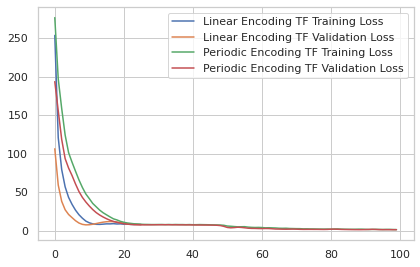

In [108]:
plt.plot(ft_linear_history.history['loss'][:100], label='Linear Encoding TF Training Loss')
plt.plot(ft_linear_history.history['val_loss'][:100], label='Linear Encoding TF Validation Loss')
plt.plot(ft_periodic_history.history['loss'][:100], label='Periodic Encoding TF Training Loss')
plt.plot(ft_periodic_history.history['val_loss'][:100], label='Periodic Encoding TF Validation Loss')
plt.legend()

#fig, ax = plt.subplots(nrows=1, ncols=2)
#ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
#ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
#ax[0].legend()
#ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
#ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
#ax[1].legend()

plt.show()

### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

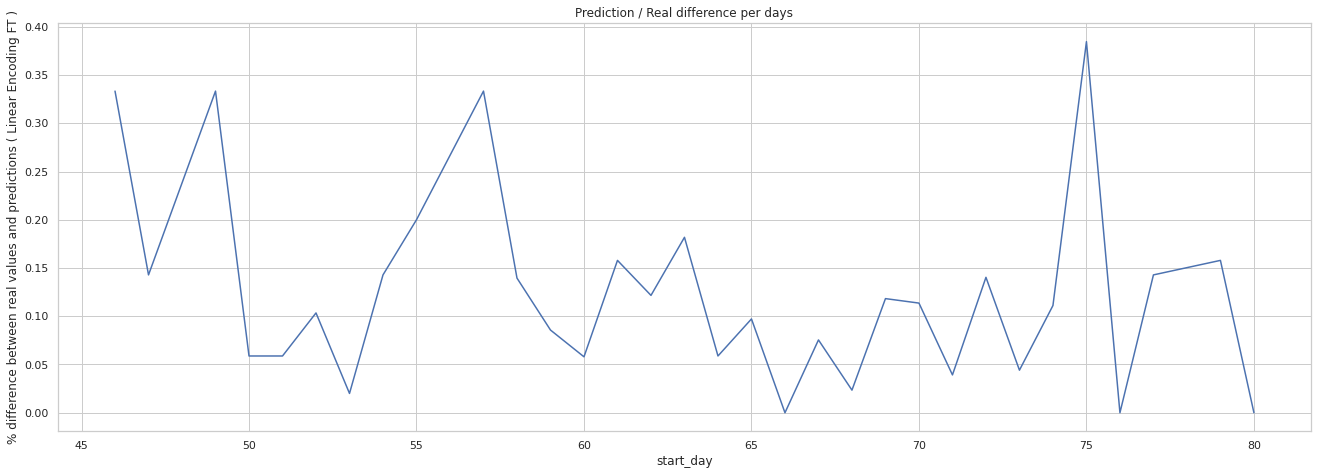

In [109]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

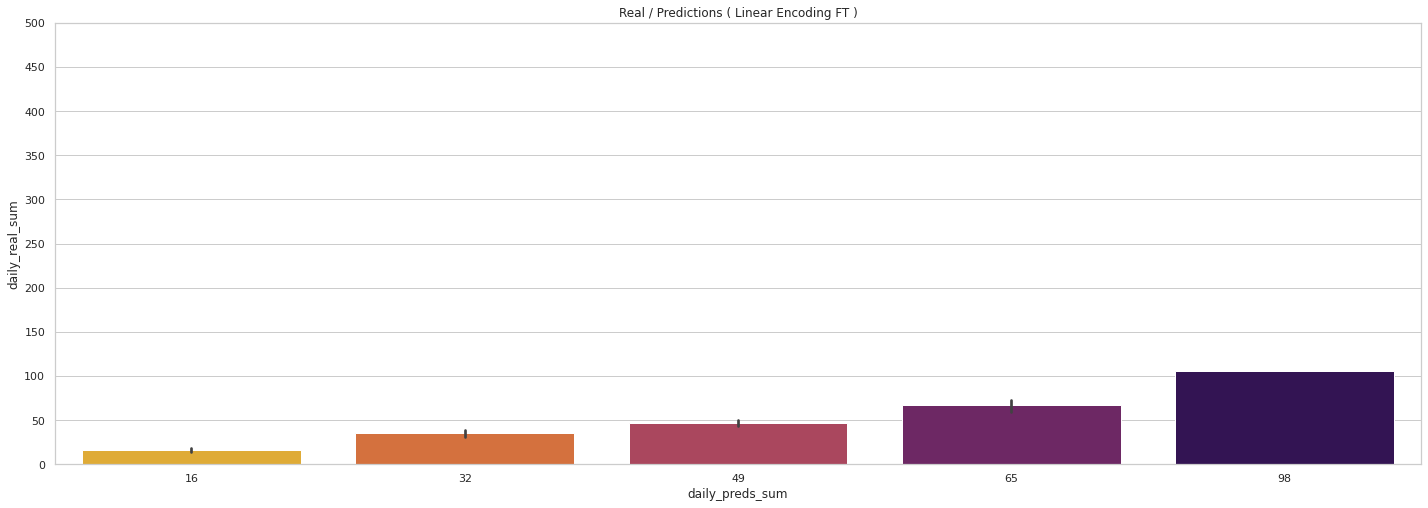

In [110]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

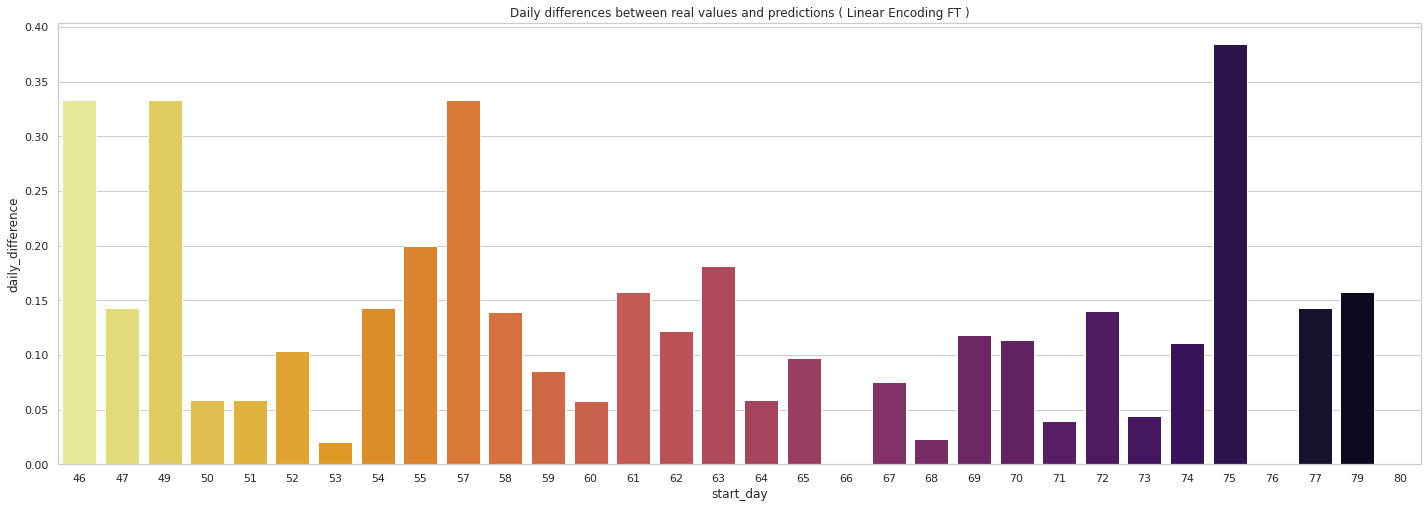

In [111]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [112]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.008235,2.535388,3.219493
Transformer - Periodic Encoding,-0.008235,2.535593,3.269573
LightGBM,0.710366,0.776520,1.725565


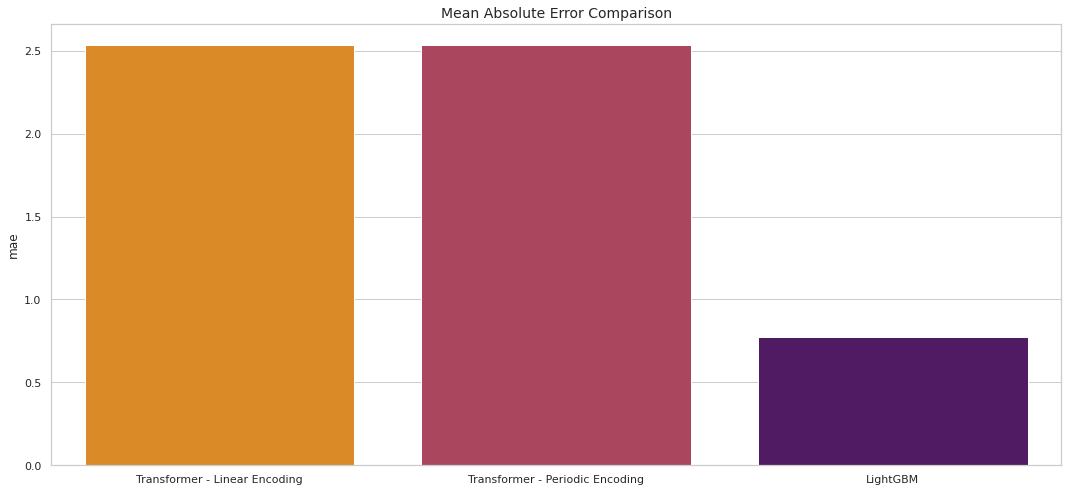

In [113]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


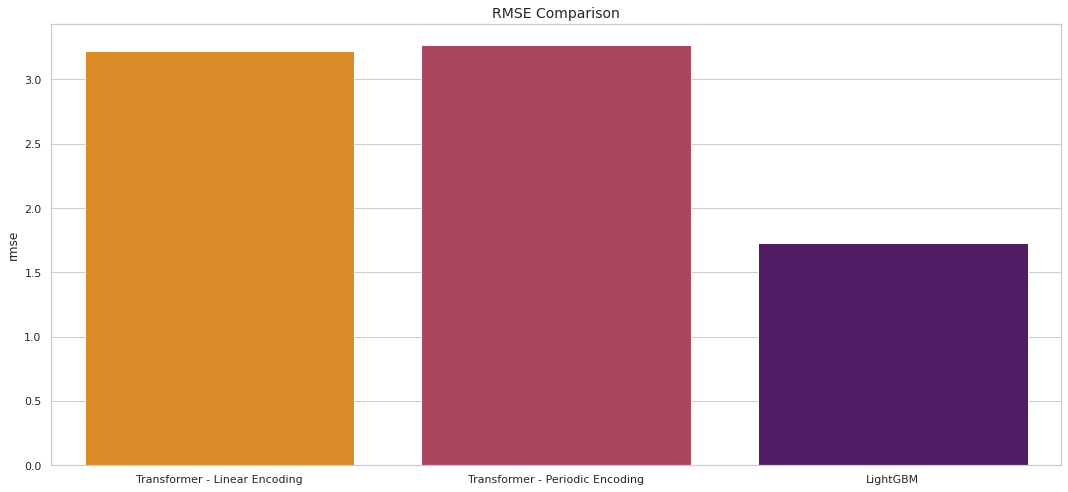

In [114]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


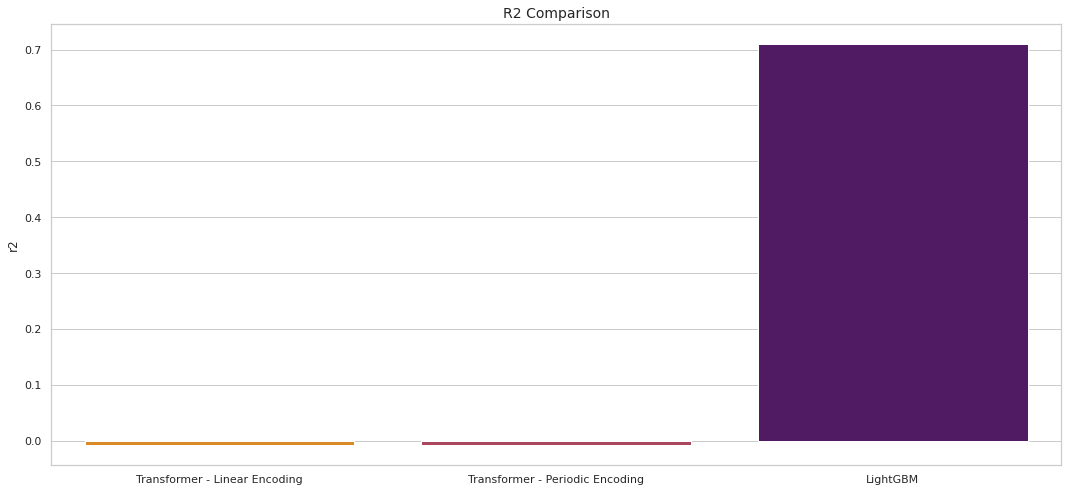

In [115]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [116]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.018397,2.533930,3.235677
Transformer - Periodic Encoding TUNED,0.636781,1.102467,1.932373
LightGBM TUNED,0.709291,0.913359,1.728763


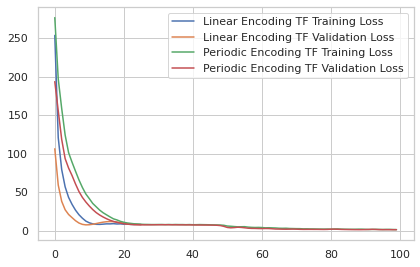

In [121]:
plt.plot(ft_linear_history.history['loss'][:100], label='Linear Encoding TF Training Loss')
plt.plot(ft_linear_history.history['val_loss'][:100], label='Linear Encoding TF Validation Loss')
plt.plot(ft_periodic_history.history['loss'][:100], label='Periodic Encoding TF Training Loss')
plt.plot(ft_periodic_history.history['val_loss'][:100], label='Periodic Encoding TF Validation Loss')
plt.legend()

#fig, ax = plt.subplots(nrows=1, ncols=2)
#ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
#ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
#ax[0].legend()
#ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
#ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
#ax[1].legend()

plt.show()

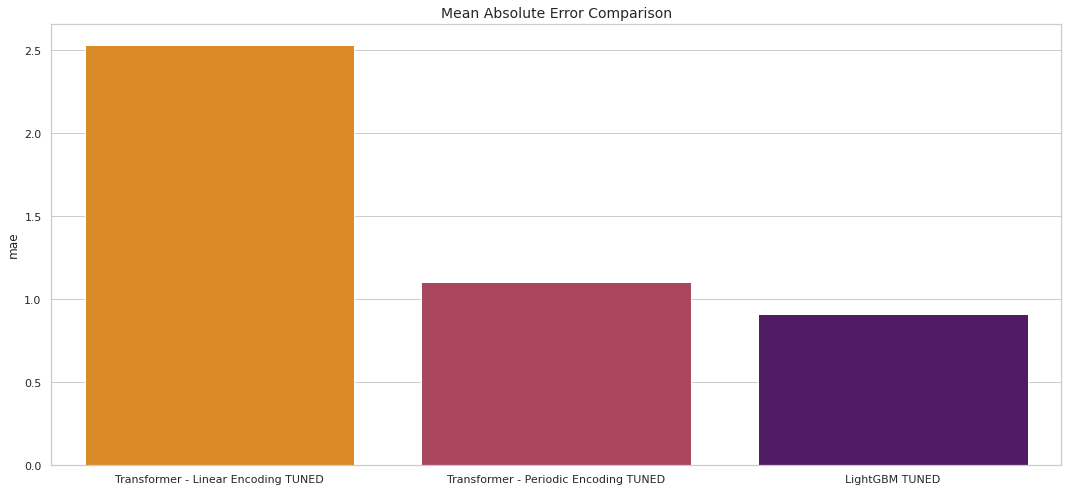

In [118]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


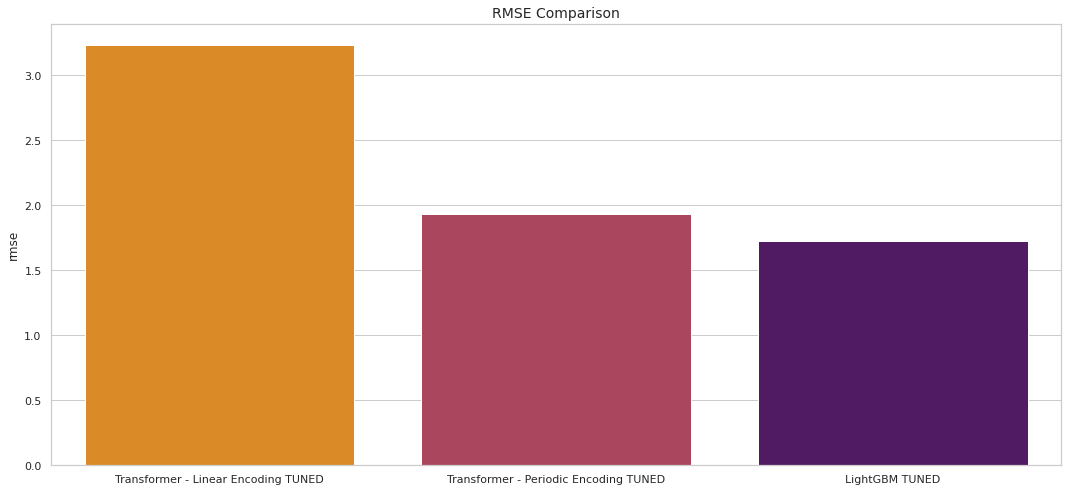

In [119]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


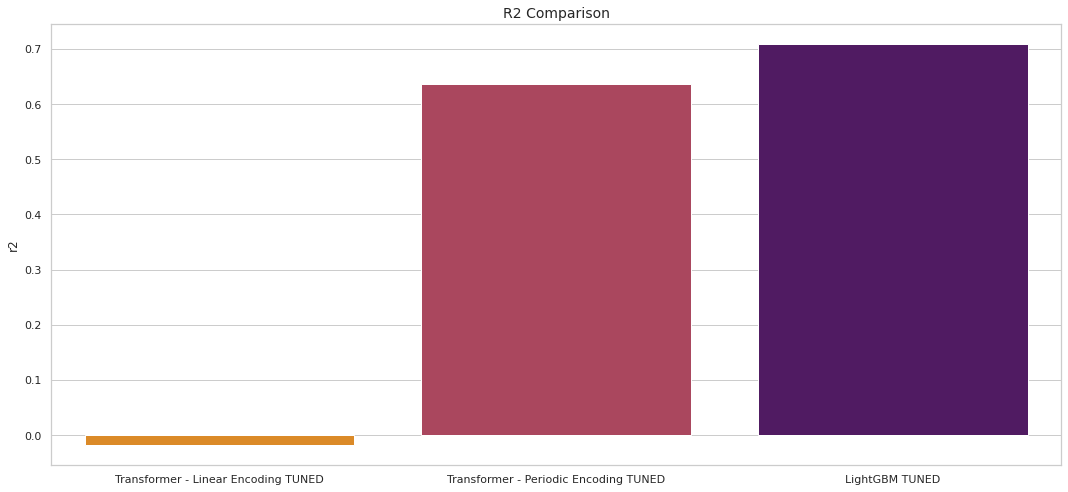

In [120]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
